In [207]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
# %pip install tableone
df = pd.read_csv('../rotterdam.csv')

In [208]:
cutoff = 10
df['er_cat'] = (df['er'] >= cutoff).astype(int)
df['pgr_cat'] = (df['pgr'] >= cutoff).astype(int)

# log(nodes + 1)
df['log_nodes'] = np.log1p(df['nodes'])

In [209]:
colors = ["#0d9634", "#bc38b1"]

In [210]:
from tableone import TableOne

num_vars = ['age', 'log_nodes']
cat_vars = ['grade', 'pgr_cat', 'er_cat', 'size']

TableOne(df, columns=num_vars + cat_vars, groupby='hormon', smd=True, pval=True)

Grouped by hormon                                                        
                                     Missing      Overall            0           1 SMD (0,1) P-Value
n                                                    2982         2643         339                  
age, mean (SD)                             0  55.1 (13.0)  54.1 (13.0)  62.5 (9.9)     0.731  <0.001
log_nodes, mean (SD)                       0    0.8 (0.9)    0.7 (0.9)   1.7 (0.7)     1.201  <0.001
grade, n (%)         2                         794 (26.6)   735 (27.8)   59 (17.4)     0.251  <0.001
                     3                        2188 (73.4)  1908 (72.2)  280 (82.6)                  
pgr_cat, n (%)       0                         951 (31.9)   814 (30.8)  137 (40.4)     0.202  <0.001
                     1                        2031 (68.1)  1829 (69.2)  202 (59.6)                  
er_cat, n (%)        0                         704 (23.6)   630 (23.8)   74 (21.8)     0.048   0.452
                     1                        2278 (76.4)  2013 (76.2)  265 (78.2)                  
size, n (%)          20-50                    1291 (43.3)  1119 (42.3)  172 (50.7)     0.409  <0.001
                     <=20                     1387 (46.5)  1283 (48.5)  104 (30.7)                  
                     >50                       304 (10.2)    241 (9.1)   63 (18.6)

<Axes: xlabel='hormon'>

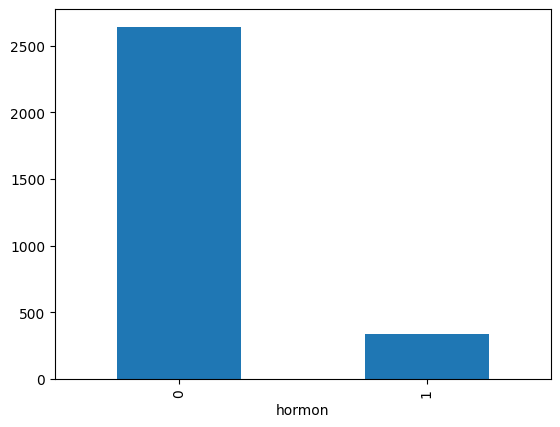

In [211]:
df["hormon"].value_counts().plot(kind="bar")

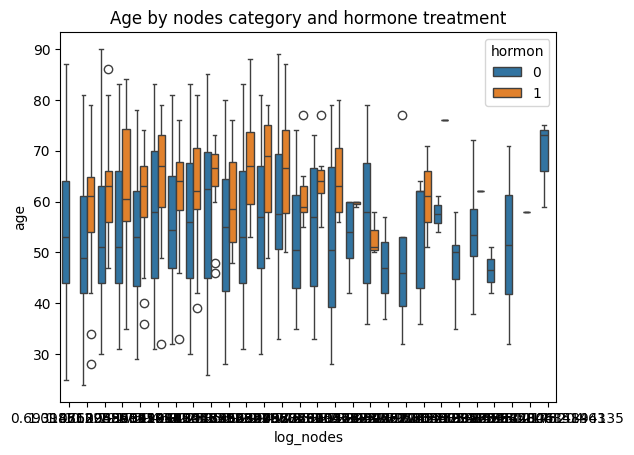

In [212]:
sns.boxplot(x="log_nodes", y="age", hue="hormon", data=df)
plt.title("Age by nodes category and hormone treatment")
plt.show()

Hormonal therapy is more frequently administered to patients with higher tumor grade, larger tumor size, greater nodal involvement, and hormone receptor positivity, and is less common among those receiving chemotherapy. Overall, these patterns confirm substantial baseline differences between treatment groups, consistent with confounding by indication.

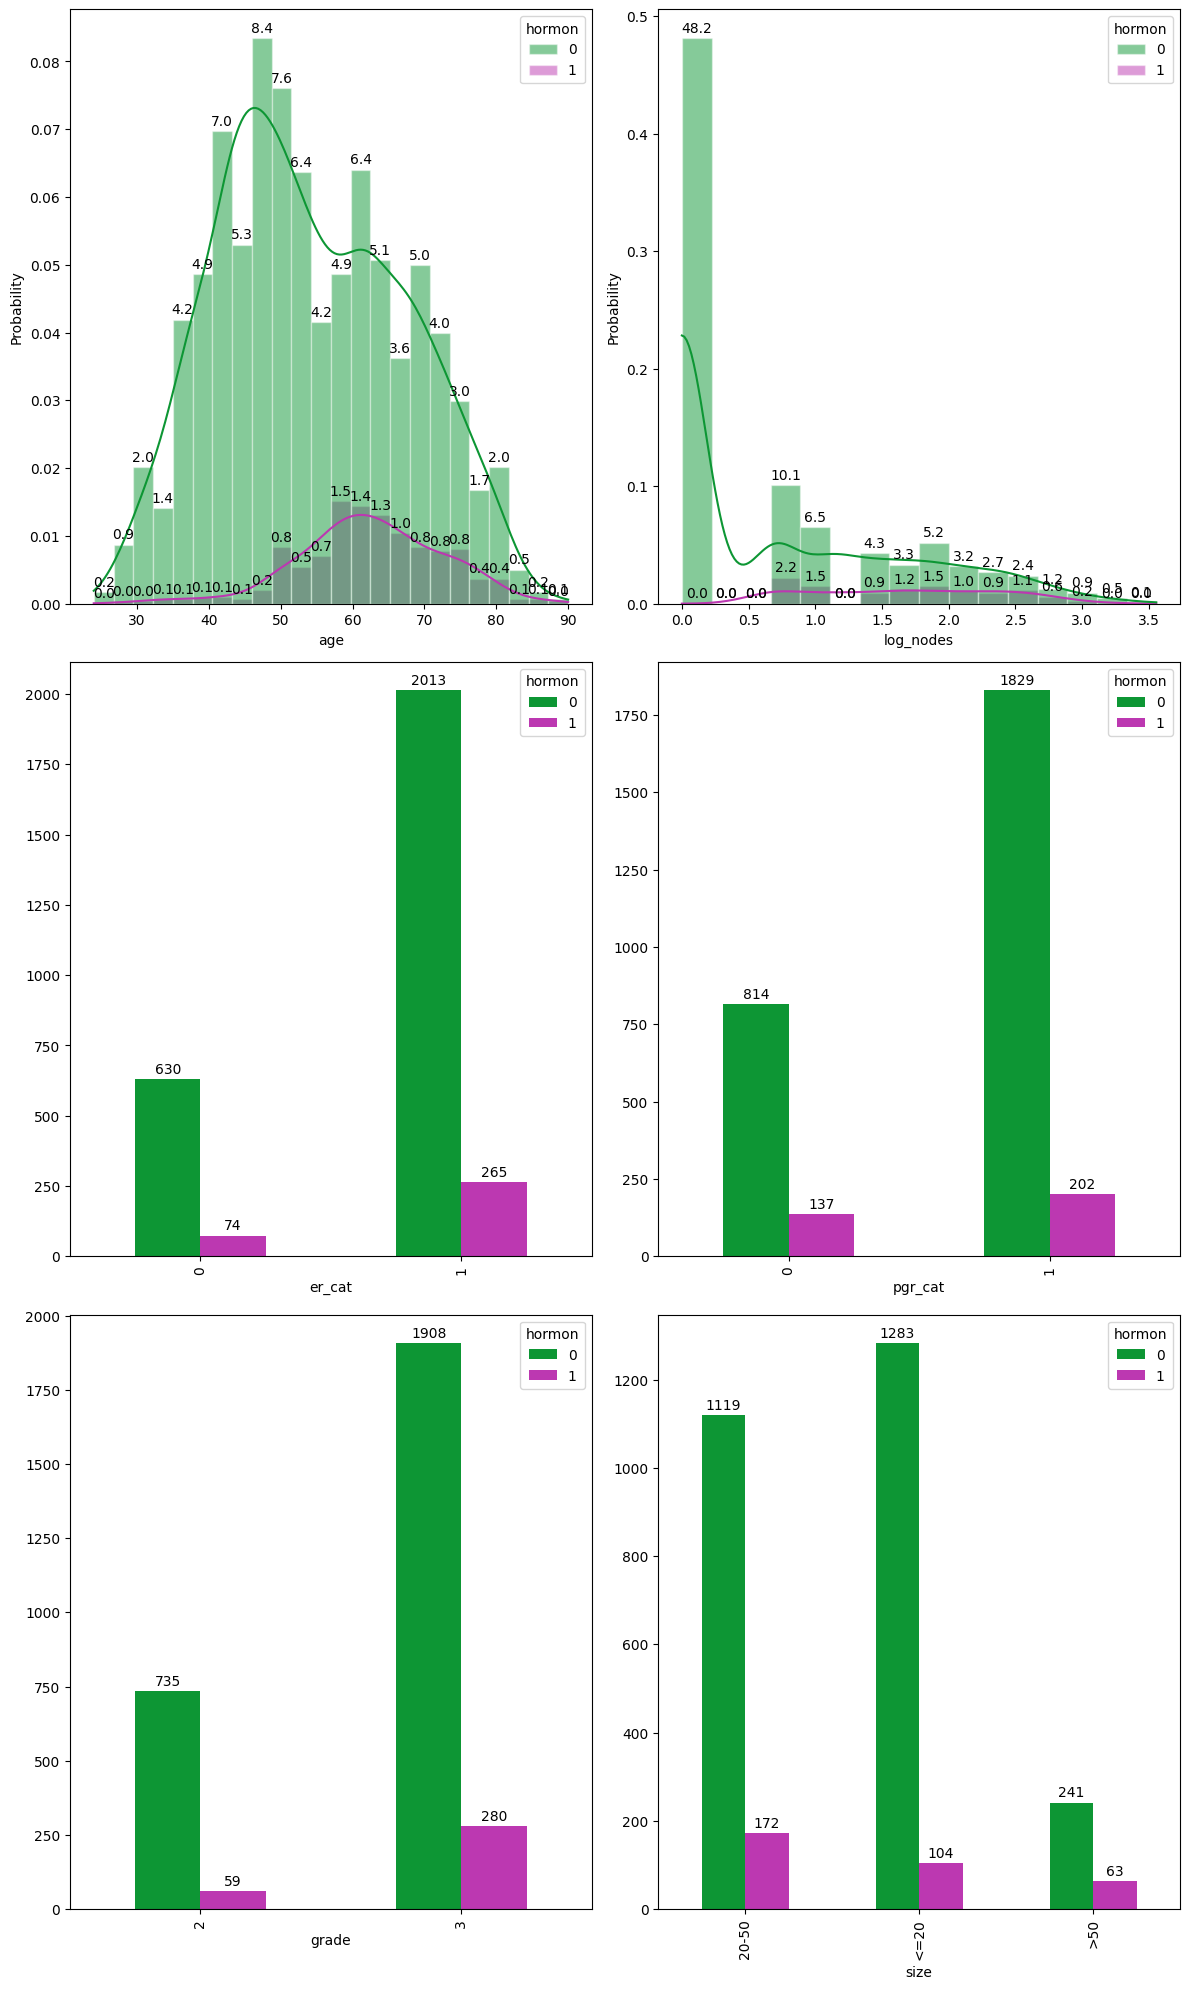

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 20))
axes = axes.flatten()

# Build histogram and categorical specs from existing notebook variables
hist_specs = [
    ("age", "Age", True, False),
    ("log_nodes", "Log(Nodes + 1)", True, False),
]

cat_specs = [
    ("er_cat", "ER Category"),
    ("pgr_cat", "PGR Category"),
    ("grade", "Grade"),
    ("size", "Size"),
]

def add_bar_labels(ax):
  for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=2)

def add_bar_labels_num(ax):
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=2, labels=[f"{v * 100:.1f}" for v in container.datavalues])

for ax, (col, _, kde, discrete) in zip(axes, hist_specs):
  sns.histplot(
    data=df, x=col, hue="hormon", kde=kde, discrete=discrete,
    edgecolor=(1, 1, 1, .4), stat="probability",
    ax=ax, palette=colors
  )
  add_bar_labels_num(ax)

for ax, (col, _) in zip(axes[len(hist_specs):], cat_specs):
  pd.crosstab(df[col], df["hormon"]).plot(
    kind="bar", stacked=False, ax=ax, color=colors
  )
  add_bar_labels(ax)

plt.tight_layout()
plt.show()

## Welch's t-test age in hormonal-therapy-treated patients

A Welch’s t-test is used to compare variables between patients treated and not treated with hormonal therapy, allowing for unequal variances. The resulting p-value assesses whether the age difference between groups is statistically significant.

In [214]:
from scipy.stats import ttest_ind

features_for_ttest = ['grade', 'pgr_cat', 'er_cat', 'size', 'age', 'log_nodes']

for col in df.columns:
    if df[col].dtype == "object" or str(df[col].dtype) == "category":
        df[col] = df[col].astype("category").cat.codes

results = []
for feature in features_for_ttest:
    group_1 = df.loc[df["hormon"] == 1, feature].dropna()
    group_0 = df.loc[df["hormon"] == 0, feature].dropna()
    t_stat, p_val = ttest_ind(group_1, group_0, equal_var=False)
    results.append({"feature": feature, "t_stat": t_stat, "p_val": p_val})

ttest_results = pd.DataFrame(results).sort_values("p_val")
ttest_results

,feature,t_stat,p_val
5,log_nodes,23.286815,1.016471e-81
4,age,14.201682,1.071766e-38
0,grade,4.647367,4.378319e-06
1,pgr_cat,-3.413997,7.026573e-04
2,er_cat,0.838291,4.023275e-01
3,size,0.244782,8.067511e-01


## Chi-Square test between categorical variables and hormonal therapy

In [215]:
from scipy.stats import chi2_contingency

significant_features = []
not_significant_features = []

for i in cat_vars:
    cont_table = pd.crosstab(df[i], df["hormon"])
    chi2, p, dof, expected = chi2_contingency(cont_table)
    if p < 0.05:
        significant_features.append(i)
    else:
        not_significant_features.append(i)
        
print("Significant features:", significant_features)
print("Not significant features:", not_significant_features)

Significant features: ['grade', 'pgr_cat', 'size']
Not significant features: ['er_cat']


In [216]:
dfc = df.drop(columns=['er', 'pgr', 'nodes', 'year','hospital_id','pid'])

In [217]:
n_both = dfc[(dfc['chemo'] == 1) & (dfc['hormon'] == 1)].shape[0]
print("Patients receiving both chemotherapy and hormonal therapy:", n_both)
print(f"Percentage: {n_both / dfc.shape[0] * 100:.2f}%")

Patients receiving both chemotherapy and hormonal therapy: 28
Percentage: 0.94%


In [218]:
# Remove patients who received both chemo and hormon therapy
dfc = dfc[~((dfc["chemo"] == 1) & (dfc["hormon"] == 1))].copy()

In [219]:
confounders = ['age', 'log_nodes', 'grade', 'size', 'er_cat', 'pgr_cat']

# Ensure df_match contains all necessary columns and is a DataFrame
df_match = dfc[confounders + ['hormon']].copy()
# It's good practice to drop rows with NaN values in confounders before matching
df_match = df_match.dropna(subset=confounders + ['hormon'])

Propensity score matching was chosen because the primary estimand of interest is the Average Treatment Effect on the Treated (ATT). Matching naturally targets the ATT by constructing a credible counterfactual for treated patients within the region of common support. In this observational setting, treatment assignment is highly non-random and not all patients are eligible for hormonal therapy, leading to confounding by indication and limited overlap. Compared to IPTW, which is more suitable for estimating the ATE and relies on stronger modeling assumptions, matching provides a more robust and clinically interpretable estimate of the treatment effect in the treated population.

In [220]:
num_vars = ['age', 'log_nodes']
cat_vars = ['grade', 'pgr_cat', 'er_cat', 'size']

# one-hot encoding of categorical features
df_match_enc = pd.concat([
    df_match.drop(columns=cat_vars),
    pd.get_dummies(df_match[cat_vars], columns=cat_vars, drop_first=True).astype(int)
], axis=1)

In [221]:
T = 'hormon'
X = df_match_enc.columns.drop([T])

# Standardize numerical variables
scaler = StandardScaler()
df_match_enc[num_vars] = scaler.fit_transform(df_match_enc[num_vars])

# Fit the logistic regression model
ps_model = LogisticRegression(C=1e6).fit(df_match_enc[X], df_match_enc[T])

# Add propensity scores to the dataset
data_ps = dfc.assign(propensity_score=ps_model.predict_proba(df_match_enc[X])[:, 1])
data_ps

,age,meno,size,grade,hormon,chemo,rtime,recur,dtime,death,er_cat,pgr_cat,log_nodes,propensity_score
0,74,1,1,3,0,0,1799,0,1799,0,1,1,0.000000,0.078656
1,79,1,0,3,0,0,2828,0,2828,0,1,1,0.000000,0.092975
2,44,0,1,2,0,0,6012,1,6012,0,0,1,0.000000,0.006460
3,70,1,0,3,0,0,2624,0,2624,0,1,0,0.000000,0.095112
4,75,1,1,3,0,0,4915,0,4915,0,1,1,0.000000,0.083263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2977,73,1,0,3,0,0,1990,1,1990,1,1,1,0.693147,0.129114
2978,75,1,2,3,1,0,45,1,45,1,1,0,2.484907,0.633632
2979,79,1,0,3,0,0,582,0,582,1,1,1,1.945910,0.450502
2980,71,1,1,3,0,0,4972,0,4972,1,1,0,0.000000,0.112639


Covariates are standardized and used in a logistic regression model to estimate each patient’s probability of receiving hormonal therapy. The resulting propensity scores are then added to the dataset to support subsequent marching.

In [222]:
data_ps['propensity_score'].describe()

count    2954.000000
mean        0.105241
std         0.134718
min         0.002122
25%         0.018981
50%         0.048532
75%         0.129071
max         0.823573
Name: propensity_score, dtype: float64

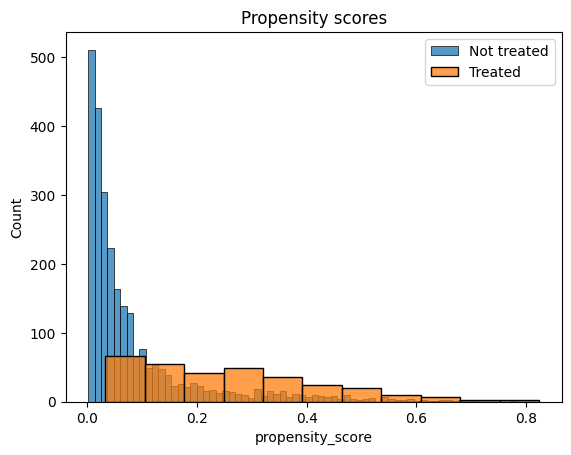

In [223]:
sns.histplot(data_ps.query("hormon==0")["propensity_score"], kde=False, label="Not treated")
sns.histplot(data_ps.query("hormon==1")["propensity_score"], kde=False, label="Treated")
plt.title("Propensity scores")
plt.legend()

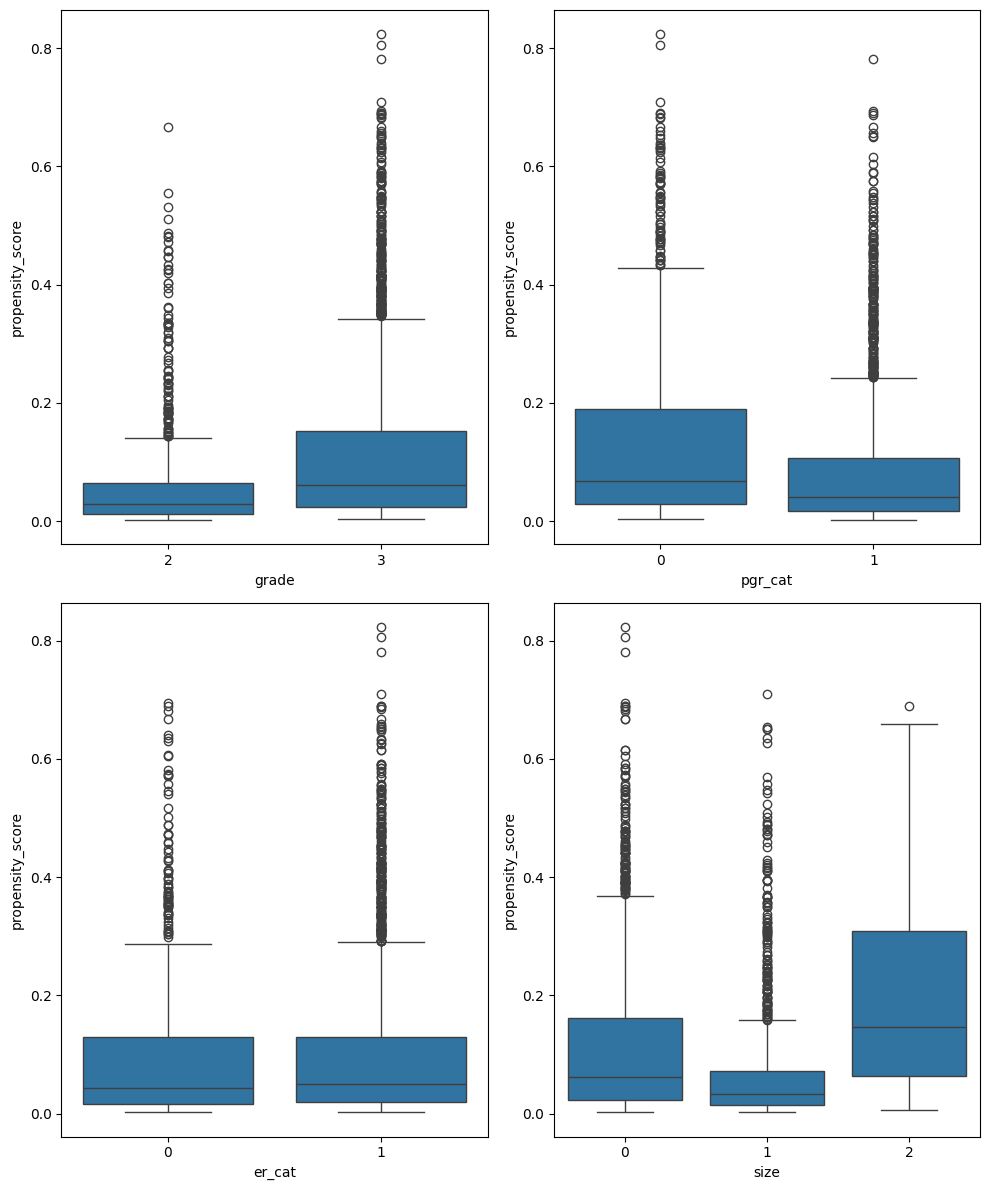

In [224]:
fig, axs = plt.subplots(nrows=int(np.ceil(len(cat_vars)/2)), ncols=2, figsize=(10, 12))
axs = axs.flatten()

for (i,c) in enumerate(cat_vars):
  sns.boxplot(x=c, y="propensity_score", data=data_ps, ax=axs[i])
fig.tight_layout()

## Optimal Matching

In [225]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# Separate treated and untreated units using 'hormon' from data_ps
treated = data_ps[data_ps['hormon'] == 1].copy()
untreated = data_ps[data_ps['hormon'] == 0].copy()

# Extract propensity scores for treated and untreated groups
ps_treated = treated['propensity_score'].values.reshape(-1, 1)
ps_untreated = untreated['propensity_score'].values.reshape(-1, 1)

# Compute the absolute differences in propensity scores as the cost matrix
# This creates a matrix where element (i, j) is |ps_treated[i] - ps_untreated[j]|
cost_matrix = cdist(ps_treated, ps_untreated, metric='cityblock')

# Solve the optimal matching using linear_sum_assignment (Hungarian algorithm)
# This finds the minimum total cost assignment between treated and untreated units
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Create a DataFrame for matched units
# Initialize 'match_id' column to keep track of matched pairs
treated_matched_df = treated.iloc[row_ind].copy()
untreated_matched_df = untreated.iloc[col_ind].copy()

# Assign a common match_id to each matched pair for easy identification
# Ensure the indices align after selection
treated_matched_df['match_id'] = range(len(row_ind))
untreated_matched_df['match_id'] = range(len(col_ind))

# Combine the matched treated and untreated units into a single DataFrame
matched_df = pd.concat([treated_matched_df, untreated_matched_df]).sort_values(by='match_id').reset_index(drop=True)
matched_df

,age,meno,size,grade,hormon,chemo,rtime,recur,dtime,death,er_cat,pgr_cat,log_nodes,propensity_score,match_id
0,55,0,2,3,1,0,1773,1,1773,0,1,0,2.302585,0.292010,0
1,55,0,2,3,0,0,1465,1,2114,1,1,0,2.302585,0.292010,0
2,49,0,0,3,0,0,77,1,969,1,1,0,2.302585,0.251045,1
3,61,1,0,3,1,0,2734,1,2734,0,1,0,1.609438,0.251529,1
4,57,1,1,3,1,0,851,0,851,0,1,0,0.693147,0.100607,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,71,1,2,3,0,0,4099,0,4099,0,1,1,1.791759,0.264442,308
618,71,1,2,3,0,0,182,1,232,1,1,0,2.708050,0.631469,309
619,75,1,2,3,1,0,45,1,45,1,1,0,2.484907,0.633632,309
620,74,1,0,3,0,0,166,1,2414,1,1,1,2.639057,0.557820,310


In [226]:
TableOne(matched_df, columns=confounders, groupby='hormon', smd=True, pval=True)

Grouped by hormon                                                        
                                 Missing      Overall            0           1 SMD (0,1) P-Value
n                                                 622          311         311                  
age, mean (SD)                         0  63.6 (10.6)  63.3 (12.1)  64.0 (8.8)     0.061   0.450
log_nodes, mean (SD)                   0    1.7 (0.8)    1.8 (0.8)   1.7 (0.7)    -0.059   0.460
grade, n (%)         2                      92 (14.8)    42 (13.5)   50 (16.1)     0.073   0.429
                     3                     530 (85.2)   269 (86.5)  261 (83.9)                  
size, n (%)          0                     333 (53.5)   177 (56.9)  156 (50.2)     0.147   0.189
                     1                     168 (27.0)    75 (24.1)   93 (29.9)                  
                     2                     121 (19.5)    59 (19.0)   62 (19.9)                  
er_cat, n (%)        0                     138 (22.2)    67 (21.5)   71 (22.8)     0.031   0.772
                     1                     484 (77.8)   244 (78.5)  240 (77.2)                  
pgr_cat, n (%)       0                     251 (40.4)   120 (38.6)  131 (42.1)     0.072   0.414
                     1                     371 (59.6)   191 (61.4)  180 (57.9)

In [227]:
len(matched_df) / len(data_ps)

0.2105619498984428

After matching, covariate balance substantially improved across all baseline characteristics. Although small residual imbalances remained for nodal status, tumor size, chemotherapy, and progesterone receptor status (SMD < 0.20), overall balance was deemed acceptable for causal inference.

The ATT was estimated because the clinical question focuses on the effect of hormonal therapy among patients who actually received the treatment. Moreover, not all patients are eligible for hormonal therapy, as treatment assignment depends on specific biological levels (e.g., hormone receptor status), making the estimation of the ATE unrealistic. In the presence of strong confounding by indication and limited overlap, focusing on the ATT yields a more credible and clinically meaningful treatment effect.

In [228]:
# Split matched data
treated_m = matched_df[matched_df['hormon'] == 1].copy()
control_m = matched_df[matched_df['hormon'] == 0].copy()

# Controllo di sicurezza
assert treated_m.shape[0] == control_m.shape[0], "Matching non 1:1"

In [229]:
ATT_recur = treated_m['recur'].mean() - control_m['recur'].mean()
ATT_recur

np.float64(-0.17684887459807075)

In [230]:
ATT_death = treated_m['death'].mean() - control_m['death'].mean()
ATT_death

np.float64(-0.21543408360128619)

Using optimal propensity score matching, we estimated the ATT by comparing outcomes between matched treated and untreated patients. Hormonal therapy showed a protective effect on recurrence and death rate among treated patients.


## Randomization Test

to analyse if the hormonal adjuvant therapy has effect on the outcome

$$ H_0: \text{the hormonal adjuvant therapy has no effect on the outcome}$$

In [231]:
from tqdm.notebook import tqdm

def randomization_test(data, outcome_col, treatment_col, match_col, n_permutations=1000, test_statistic="mean"):
    # Compute observed test statistic
    treated = data[data[treatment_col] == 1]
    untreated = data[data[treatment_col] == 0]
    observed_stat = treated[outcome_col].mean() - untreated[outcome_col].mean()

    if test_statistic == "median":
        observed_stat = treated[outcome_col].median() - untreated[outcome_col].median()

    # Initialize array to store permuted statistics
    permuted_stats = np.zeros(n_permutations)

    # Perform permutations
    for i in tqdm(range(n_permutations)):
        # Shuffle treatment labels within matched pairs
        permuted_data = data.copy()
        for match_id in data[match_col].unique():
            mask = data[match_col] == match_id
            permuted_labels = np.random.permutation(data.loc[mask, treatment_col].values)
            permuted_data.loc[mask, treatment_col] = permuted_labels

        # Calculate permuted test statistic
        perm_treated = permuted_data[permuted_data[treatment_col] == 1]
        perm_untreated = permuted_data[permuted_data[treatment_col] == 0]
        perm_stat = perm_treated[outcome_col].mean() - perm_untreated[outcome_col].mean()

        if test_statistic == "median":
            perm_stat = perm_treated[outcome_col].median() - perm_untreated[outcome_col].median()

        permuted_stats[i] = perm_stat

    # Compute p-value
    p_value = np.mean(np.abs(permuted_stats) >= np.abs(observed_stat))

    return p_value, observed_stat, permuted_stats

  0%|          | 0/100 [00:00<?, ?it/s]

Observed Statistic: -0.17684887459807075
P-value: 0.0


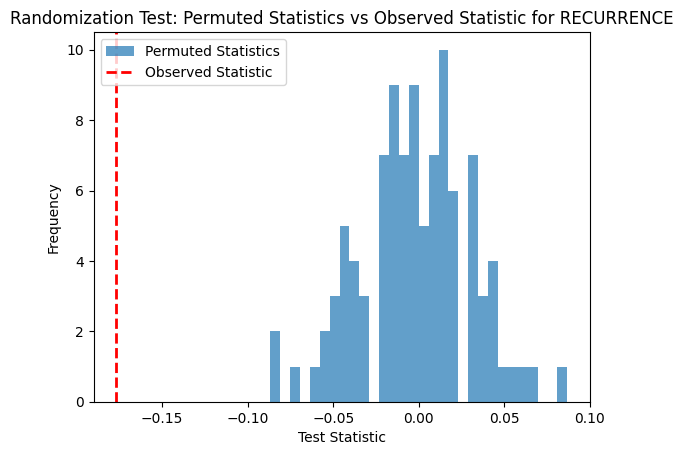

In [232]:
p_value, observed_stat, permuted_stats = randomization_test(
    data=matched_df,
    outcome_col="recur",
    treatment_col="hormon",
    match_col="match_id",
    n_permutations=100,
    test_statistic="mean"  # Or "median"
)

print(f"Observed Statistic: {observed_stat}")
print(f"P-value: {p_value}")

plt.hist(permuted_stats, bins=30, alpha=0.7, label="Permuted Statistics")
plt.axvline(observed_stat, color='red', linestyle='dashed', linewidth=2, label="Observed Statistic")
plt.title("Randomization Test: Permuted Statistics vs Observed Statistic for RECURRENCE")
plt.xlabel("Test Statistic")
plt.ylabel("Frequency")
plt.legend()
plt.show()


The paired permutation test yielded an observed statistic of −0.176..., indicating a substantially lower outcome rate among treated patients compared with their matched controls. The observed effect lay far in the tail of the null distribution, with no permuted statistic exceeding it (p < 0.001), providing strong, model-free evidence of a protective treatment effect.

In [233]:
from statsmodels.api import Logit, add_constant

X = add_constant(matched_df[["hormon"]])
model = Logit(matched_df["recur"], X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.649467
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  recur   No. Observations:                  622
Model:                          Logit   Df Residuals:                      620
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Feb 2026   Pseudo R-squ.:                 0.02498
Time:                        17:32:33   Log-Likelihood:                -403.97
converged:                       True   LL-Null:                       -414.32
Covariance Type:            nonrobust   LLR p-value:                 5.381e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8673      0.124      6.981      0.000       0.624       1.111
hormon        -0.7578      0.

  0%|          | 0/100 [00:00<?, ?it/s]

Observed Statistic: -0.21543408360128619
P-value: 0.0


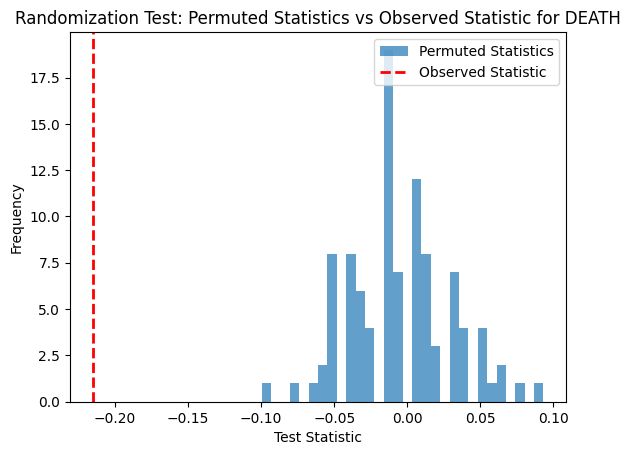

In [234]:
p_value, observed_stat, permuted_stats = randomization_test(
    data=matched_df,
    outcome_col="death",
    treatment_col="hormon",
    match_col="match_id",
    n_permutations=100,
    test_statistic="mean"  # Or "median"
)

print(f"Observed Statistic: {observed_stat}")
print(f"P-value: {p_value}")

# Visualize the distribution of permuted statistics
import matplotlib.pyplot as plt

plt.hist(permuted_stats, bins=30, alpha=0.7, label="Permuted Statistics")
plt.axvline(observed_stat, color='red', linestyle='dashed', linewidth=2, label="Observed Statistic")
plt.title("Randomization Test: Permuted Statistics vs Observed Statistic for DEATH")
plt.xlabel("Test Statistic")
plt.ylabel("Frequency")
plt.legend()
plt.show()

For the mortality outcome, the paired permutation test yielded an observed statistic of −0.224, indicating a marked reduction in death among treated patients compared with their matched controls. The observed effect lay entirely outside the permutation distribution, with no permuted statistic as extreme as the observed one (p < 0.001), providing strong non-parametric evidence of a protective treatment effect.

In [235]:
X = add_constant(matched_df[['hormon']])
model = Logit(matched_df['death'], X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.651387
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  622
Model:                          Logit   Df Residuals:                      620
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Feb 2026   Pseudo R-squ.:                 0.03592
Time:                        17:32:44   Log-Likelihood:                -405.16
converged:                       True   LL-Null:                       -420.26
Covariance Type:            nonrobust   LLR p-value:                 3.918e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8519      0.124      6.878      0.000       0.609       1.095
hormon        -0.9098      0.

## COX Model to analyse Rtime/Dtime

### dtime

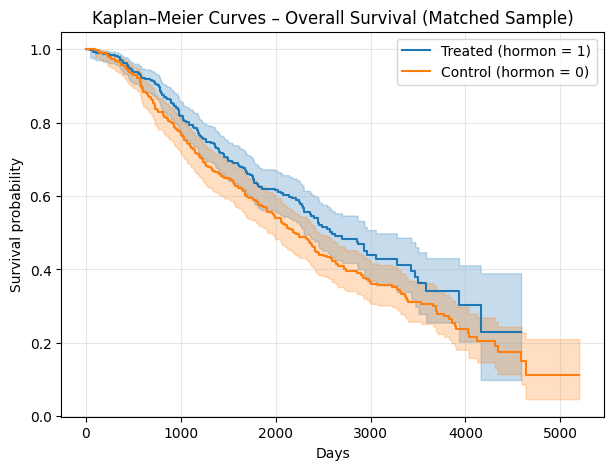

In [236]:
from lifelines import KaplanMeierFitter

# Dataset matched
df_km = matched_df[['dtime', 'death', 'hormon', 'match_id']].dropna().copy()

T_col = "dtime"
E_col = "death"
G_col = "hormon"

df_treated = df_km[df_km[G_col] == 1]
df_control = df_km[df_km[G_col] == 0]

kmf_t = KaplanMeierFitter()
kmf_c = KaplanMeierFitter()

plt.figure(figsize=(7, 5))

kmf_t.fit(
    durations=df_treated[T_col],
    event_observed=df_treated[E_col],
    label="Treated (hormon = 1)"
)
ax = kmf_t.plot(ci_show=True)

kmf_c.fit(
    durations=df_control[T_col],
    event_observed=df_control[E_col],
    label="Control (hormon = 0)"
)
kmf_c.plot(ax=ax, ci_show=True)

plt.title("Kaplan–Meier Curves – Overall Survival (Matched Sample)")
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.show()

In the propensity score–matched cohort, Kaplan–Meier analysis of overall survival shows a modest separation between treated and untreated patients, emerging after approximately 2–3 years of follow-up. While the treated group consistently displays higher survival probabilities, confidence intervals overlap at later time points, reflecting increasing uncertainty due to limited numbers at risk. These findings suggest that the survival benefit of hormone therapy on overall mortality is indirect and likely mediated through its effect on recurrence (next graph) reduction rather than an early or strong mortality impact.

In [237]:
from lifelines import CoxPHFitter

# Dataset per Cox
df_cox_d = matched_df[['dtime', 'death', 'hormon', 'match_id']].copy()

# Controllo
df_cox_d['hormon'].value_counts()

hormon
1    311
0    311
Name: count, dtype: int64

In [238]:
cph_d = CoxPHFitter()

cph_d.fit(
    df_cox_d,
    duration_col='dtime',
    event_col='death',
    strata=['match_id']
)

cph_d.print_summary()

<lifelines.CoxPHFitter: fitted with 622 total observations, 253 right-censored observations>
             duration col = 'dtime'
                event col = 'death'
                   strata = match_id
      baseline estimation = breslow
   number of observations = 622
number of events observed = 369
   partial log-likelihood = -141.72
         time fit was run = 2026-02-06 16:32:44 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
hormon    -0.26      0.77      0.14           -0.54            0.01                0.58                1.01

           cmp to     z    p  -log2(p)
covariate                             
hormon       0.00 -1.87 0.06      4.03
---
Concordance = 0.57
Partial AIC = 285.43
log-likelihood ratio test = 3.53 on 1 df
-log2(p) of ll-ratio test = 4.05

<Axes: xlabel='HR (95% CI)'>

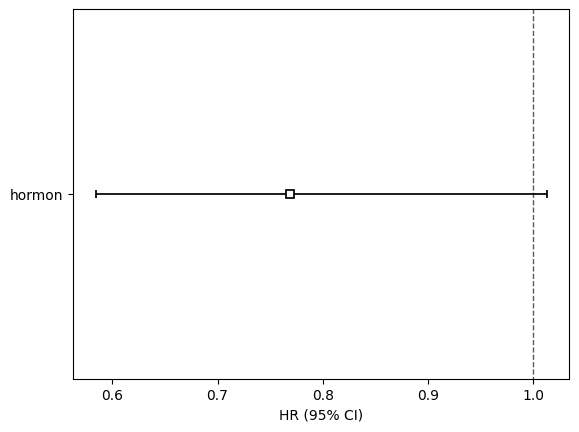

In [239]:
cph_d.plot(hazard_ratios=True)

In the stratified Cox model fitted on the matched cohort, hormone therapy was associated with a 23% reduction in the hazard of death (HR = 0.77, 95% CI 0.58–1.01), although the effect did not reach conventional statistical significance (p = 0.06). This borderline result is consistent with the modest and time-dependent separation observed in the matched Kaplan–Meier overall survival curves, suggesting a delayed and indirect survival benefit.

### rtime

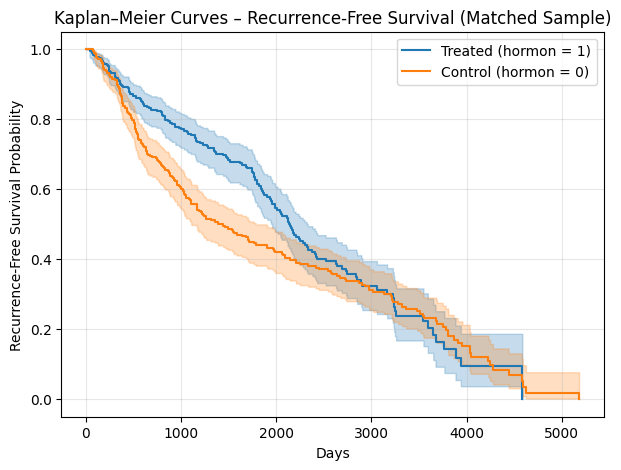

In [240]:
# Dataset matched
df_km = matched_df[['rtime', 'recur', 'hormon', 'match_id']].dropna().copy()

T_col = "rtime"
E_col = "recur"
G_col = "hormon"

df_treated = df_km[df_km[G_col] == 1]
df_control = df_km[df_km[G_col] == 0]

kmf_t = KaplanMeierFitter()
kmf_c = KaplanMeierFitter()

plt.figure(figsize=(7, 5))

kmf_t.fit(
    durations=df_treated[T_col],
    event_observed=df_treated[E_col],
    label="Treated (hormon = 1)"
)
ax = kmf_t.plot(ci_show=True)

kmf_c.fit(
    durations=df_control[T_col],
    event_observed=df_control[E_col],
    label="Control (hormon = 0)"
)
kmf_c.plot(ax=ax, ci_show=True)

plt.title("Kaplan–Meier Curves – Recurrence-Free Survival (Matched Sample)")
plt.xlabel("Days")
plt.ylabel("Recurrence-Free Survival Probability")
plt.grid(alpha=0.3)
plt.show()

In the propensity score–matched cohort, Kaplan–Meier curves for recurrence-free survival show a delayed separation between treated and untreated patients, becoming evident approximately 2 years after diagnosis and persisting up to 5 years. This finding suggests that hormone therapy primarily reduces mid-term recurrence risk rather than early relapse. Beyond 8 years of follow-up, survival curves converge and confidence intervals widen, indicating increased uncertainty due to the limited number of patients at risk.


In [241]:
df_cox_r = matched_df[['rtime', 'recur', 'hormon', 'match_id']].copy()

df_cox_r['hormon'].value_counts()

hormon
1    311
0    311
Name: count, dtype: int64

In [242]:
cph_r = CoxPHFitter()

cph_r.fit(
    df_cox_r,
    duration_col='rtime',
    event_col='recur',
    strata=['match_id']
)

cph_r.print_summary()

<lifelines.CoxPHFitter: fitted with 622 total observations, 239 right-censored observations>
             duration col = 'rtime'
                event col = 'recur'
                   strata = match_id
      baseline estimation = breslow
   number of observations = 622
number of events observed = 383
   partial log-likelihood = -128.38
         time fit was run = 2026-02-06 16:32:48 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
hormon    -0.41      0.66      0.15           -0.70           -0.12                0.49                0.88

           cmp to     z    p  -log2(p)
covariate                             
hormon       0.00 -2.80 0.01      7.62
---
Concordance = 0.60
Partial AIC = 258.76
log-likelihood ratio test = 8.02 on 1 df
-log2(p) of ll-ratio test = 7.76

<Axes: xlabel='HR (95% CI)'>

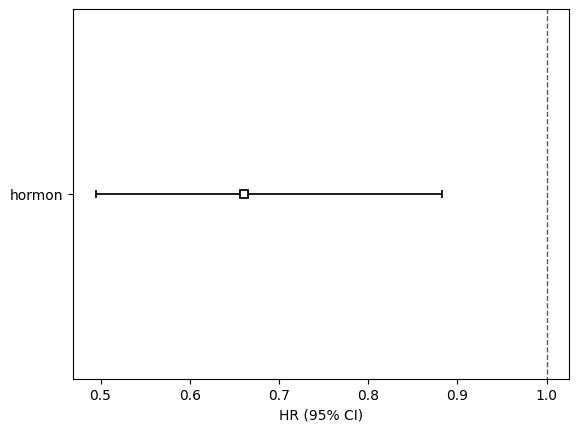

In [243]:
cph_r.plot(hazard_ratios=True)